The objective is to develop audio recognition for initiating commands with brief trigger words, specifically tailored for non-commercial voice assistants. The designated keyword for recognition is "Marvin."

The dataset for training encompasses audio snippets covering various conversational scenarios, including background noise, to enhance the model's ability to recognize "Marvin" amidst real-world conditions.

In [1]:
#!pip install -U -q tensorflow tensorflow_datasets

Load the libraries

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

import soundfile as sf
import librosa
import librosa.display
import matplotlib.pyplot as plt

from tensorflow import keras

import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2023-12-18 18:31:52.171615: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load and clean dataset

Load precleaned dataset

The dataset's audio clips are stored in 2 folders corresponding to speech command:

In [3]:
DATASET_PATH = './wake-word-examples/train/'
data_dir = DATASET_PATH
# if not load the data https://drive.google.com/uc?export=download&id=11NAqQ-T2xRd1LHT3hhT7W94F15fn6dvn


In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['not-wake-word' 'wake-word']


Resample audio with union sample rate

In [5]:

"""The dataset's audio clips are stored in 2 folders corresponding to speech command:"""

def resample_audio(label):
  directory = data_dir+label
  audio_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.wav')]
  for file_path in audio_files:
    audio_signal, current_sampling_rate = librosa.load(file_path, sr=None)  # sr=None returns the native sampling rate

    # Set the target sampling rate
    target_sampling_rate = 16000

    # Resample the audio signal
    resampled_audio = librosa.resample(audio_signal, orig_sr = current_sampling_rate, target_sr = target_sampling_rate)

    path = 'resample/'+label+"/"
    # Check whether the specified path exists or not
    isExist = os.path.exists(path)
    if not isExist:
      os.makedirs(path)
    output_file_path = './resample/'+label+"/"+file_path.split('/')[-1]  # Replace this with the desired file path

    # Save the audio signal to a WAV file
    sf.write(output_file_path, data=resampled_audio, samplerate = target_sampling_rate)
  return "resample_audio done!"


In [6]:
label = 'not-wake-word'
resample_audio(label)
label = 'wake-word'
resample_audio(label)

'resample_audio done!'

Load the datasets

In [7]:
DATASET_PATH = './resample'
data_dir = pathlib.Path(DATASET_PATH)

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    shuffle=True,
    output_sequence_length=32000,
    subset='both',
    )

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 7751 files belonging to 2 classes.
Using 6201 files for training.
Using 1550 files for validation.

label names: ['not-wake-word' 'wake-word']


Create massive of the labesto find the weights

In [8]:
labels_array = np.concatenate([y.numpy() for _, y in train_ds], axis=0)

The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`.

In [9]:
val_ds.element_spec

(TensorSpec(shape=(None, 32000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [10]:
train_ds.element_spec

(TensorSpec(shape=(None, 32000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [11]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

brake data on test and val split

In [12]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

### **EDA**



find the example

In [13]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 32000)
(64,)


Let's plot a few audio waveforms:

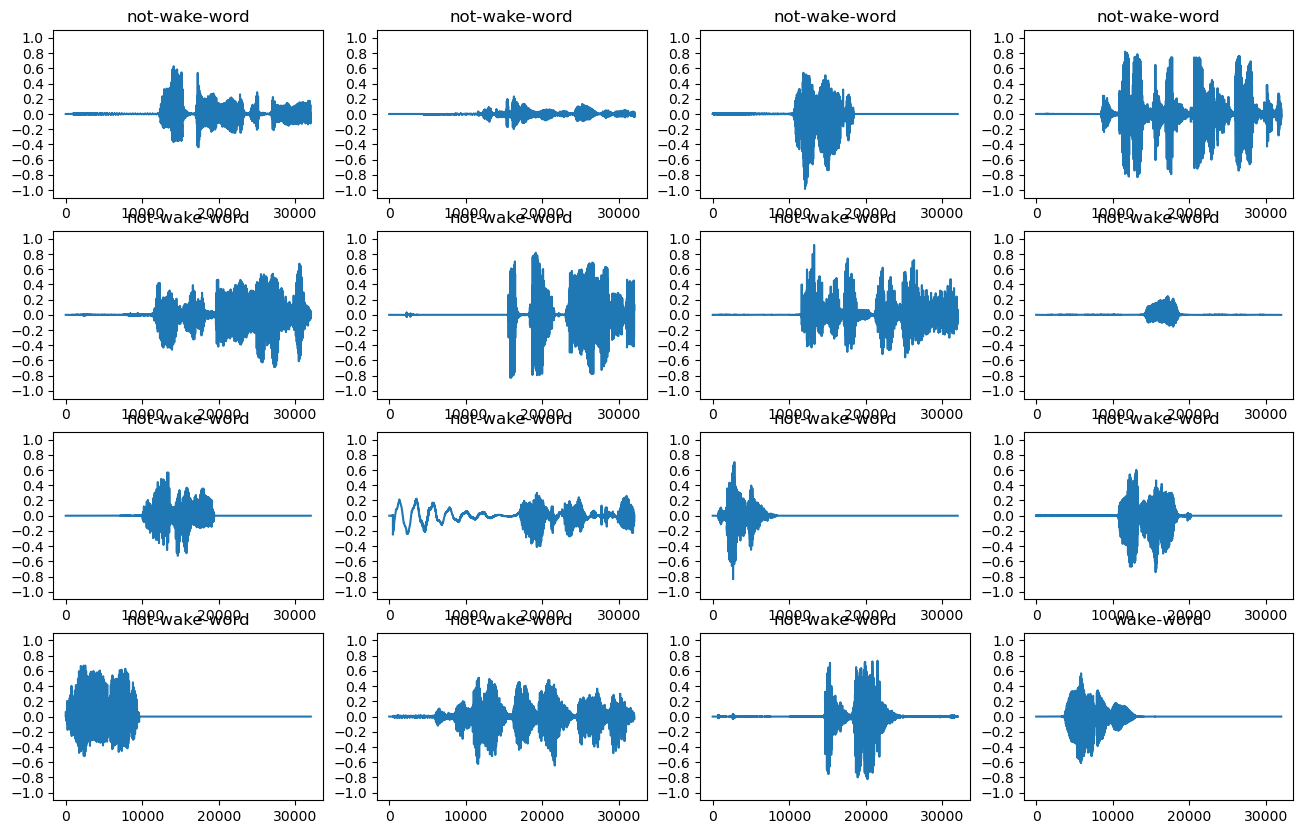

In [14]:
plt.figure(figsize=(16, 10))
rows = 4
cols = 4
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [15]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [16]:
for i in range(10):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: not-wake-word
Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)
Audio playback


Label: not-wake-word
Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)
Audio playback


Label: not-wake-word
Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)
Audio playback


Label: not-wake-word
Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)
Audio playback


Label: not-wake-word
Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)
Audio playback


Label: not-wake-word
Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)
Audio playback


Label: not-wake-word
Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)
Audio playback


Label: not-wake-word
Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)
Audio playback


Label: not-wake-word
Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)
Audio playback


Label: not-wake-word
Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [17]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

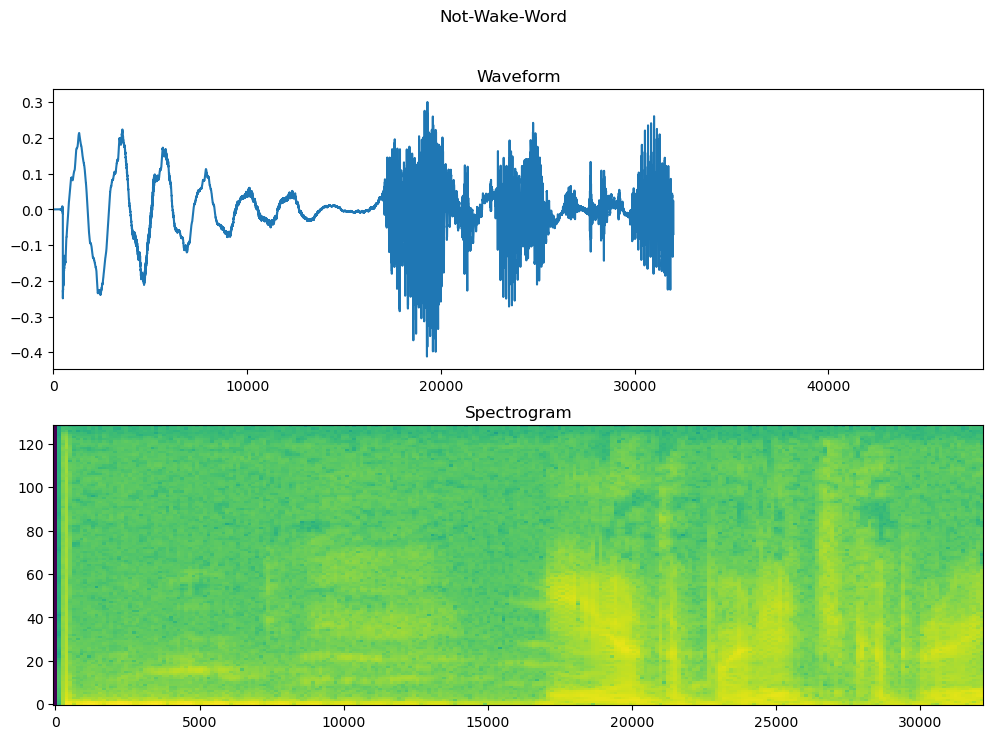

In [18]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 48000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogram datasets from the audio datasets:

In [19]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [20]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [21]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

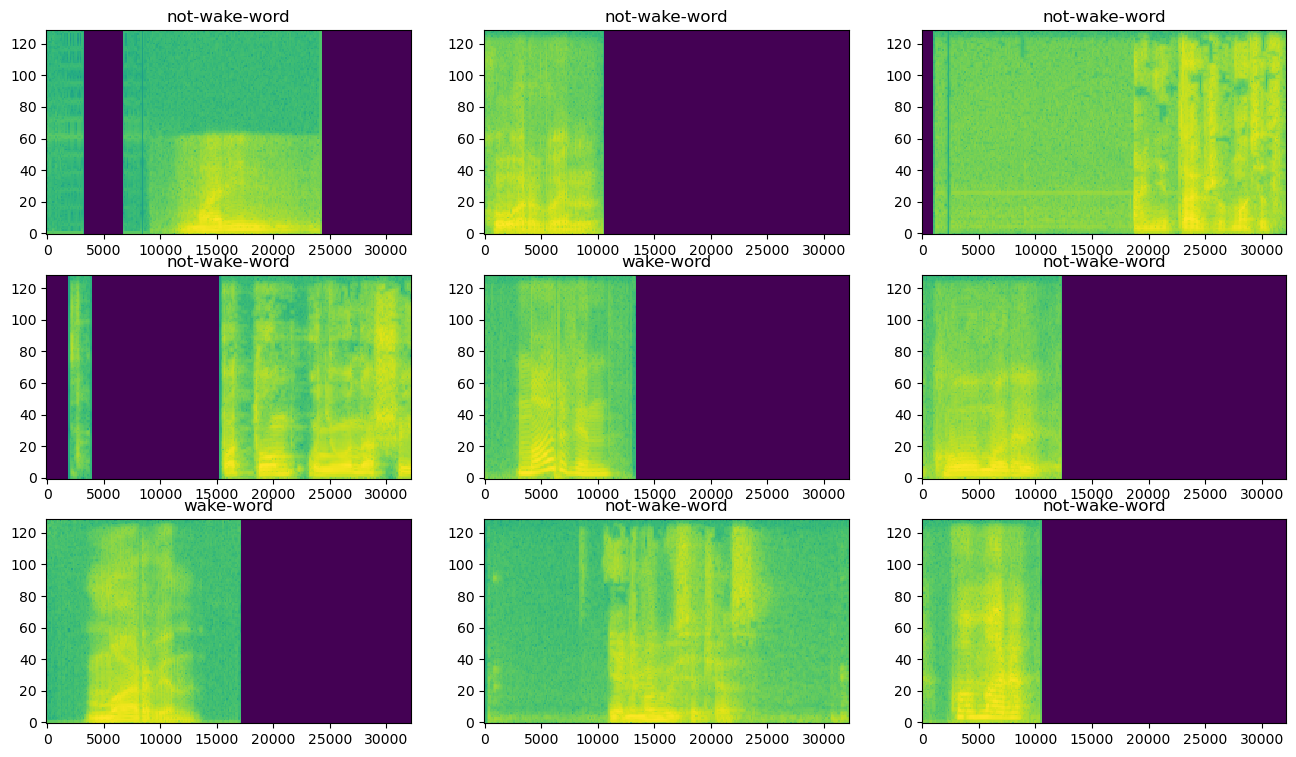

In [22]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [23]:
train_spectrogram_ds = train_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

Calculate class weights

In [24]:

class_weights = compute_class_weight('balanced', classes=np.unique(labels_array), y=labels_array)

# Convert class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))

Building the model is straightforward. A simple Convolutional Neural Network (CNN) is chosen, leveraging the transformed audio files presented as spectrogram images.

The model, defined using tf.keras.Sequential, incorporates key Keras preprocessing layers:

tf.keras.layers.Resizing: Downsampling the input to expedite model training.
tf.keras.layers.Normalization: Normalizing each pixel in the image based on its mean and standard deviation.
Prior to using the Normalization layer, the adapt method must be invoked on the training data. This step is crucial for computing aggregate statistics, specifically the mean and standard deviation.

In [25]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

Input shape: (249, 129, 1)


Define model

In [26]:
def make_model(learning_rate = 0.01, dropout_rate = 0.1):
      model = models.Sequential([
          layers.Input(shape=input_shape),
          # Downsample the input.
          layers.Resizing(32, 32),
          # Normalize.
          norm_layer,
          layers.Conv2D(32, 3, activation='relu'),
          layers.Conv2D(64, 3, activation='relu'),
          layers.MaxPooling2D(),
          layers.Dropout(dropout_rate),
          layers.Flatten(),
          layers.Dense(128, activation='relu'),
          layers.Dropout(dropout_rate),
          layers.Dense(num_labels)
      ])
      model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'], sample_weight_mode=class_weight_dict,
        )

      return model

Cheakpoints

In [27]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'Sequential_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only = True,
    monitor = 'val_accuracy',
    mode = 'max'
)

See what gives the best results

In [28]:
scores = {}

for learning_rate in [0.001,0.01, 0.1, 1]:
    print(learning_rate)
    model = make_model(learning_rate = learning_rate)
    EPOCHS = 5
    history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)
    scores[learning_rate]=history.history
    print()
    print()



0.001
Epoch 1/5
97/97 [==============================] - 22s 210ms/step - loss: 0.2003 - accuracy: 0.9052 - val_loss: 0.1693 - val_accuracy: 0.9297
Epoch 2/5
97/97 [==============================] - 19s 199ms/step - loss: 0.1494 - accuracy: 0.9323 - val_loss: 0.1276 - val_accuracy: 0.9466
Epoch 3/5
97/97 [==============================] - 20s 202ms/step - loss: 0.1194 - accuracy: 0.9453 - val_loss: 0.1000 - val_accuracy: 0.9557
Epoch 4/5
97/97 [==============================] - 20s 210ms/step - loss: 0.0906 - accuracy: 0.9679 - val_loss: 0.0786 - val_accuracy: 0.9688
Epoch 5/5
97/97 [==============================] - 20s 210ms/step - loss: 0.0724 - accuracy: 0.9823 - val_loss: 0.0636 - val_accuracy: 0.9792


0.01
Epoch 1/5
97/97 [==============================] - 23s 216ms/step - loss: 0.2981 - accuracy: 0.9184 - val_loss: 0.1601 - val_accuracy: 0.9466
Epoch 2/5
97/97 [==============================] - 15s 156ms/step - loss: 0.1493 - accuracy: 0.9418 - val_loss: 0.1418 - val_accuracy: 

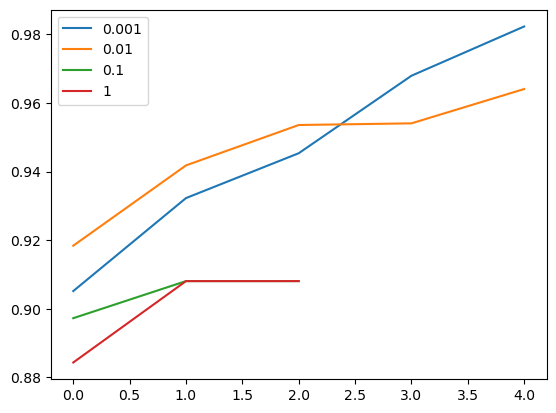

In [29]:
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label = lr)
    #plt.xtick(np.arange(10))
    plt.legend()

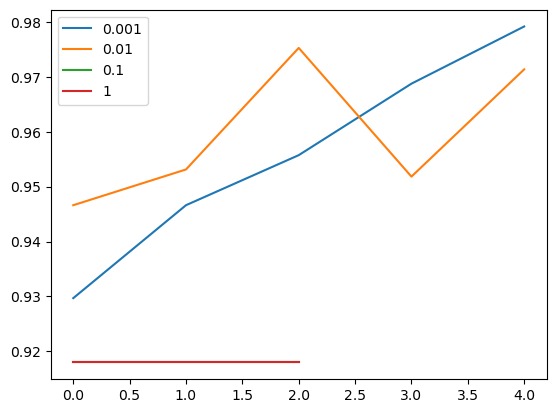

In [30]:
for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label = lr)
    #plt.xtick(np.arange(10))
    plt.legend()

In [31]:
scores = {}

for dropout_rate in [0.1,0.4, 0.8]:
    print(dropout_rate)
    model = make_model(dropout_rate = dropout_rate)
    EPOCHS = 5
    history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)
    scores[dropout_rate]=history.history
    print()
    print()

0.1
Epoch 1/5
97/97 [==============================] - 19s 177ms/step - loss: 0.2576 - accuracy: 0.9007 - val_loss: 0.1784 - val_accuracy: 0.9180
Epoch 2/5
97/97 [==============================] - 17s 178ms/step - loss: 0.1674 - accuracy: 0.9287 - val_loss: 0.1323 - val_accuracy: 0.9401
Epoch 3/5
97/97 [==============================] - 17s 175ms/step - loss: 0.1399 - accuracy: 0.9466 - val_loss: 0.1062 - val_accuracy: 0.9583
Epoch 4/5
97/97 [==============================] - 23s 236ms/step - loss: 0.1211 - accuracy: 0.9553 - val_loss: 0.0826 - val_accuracy: 0.9688
Epoch 5/5
97/97 [==============================] - 21s 216ms/step - loss: 0.0997 - accuracy: 0.9603 - val_loss: 0.0933 - val_accuracy: 0.9661


0.4
Epoch 1/5
97/97 [==============================] - 27s 256ms/step - loss: 0.3047 - accuracy: 0.9078 - val_loss: 0.1786 - val_accuracy: 0.9427
Epoch 2/5
97/97 [==============================] - 21s 220ms/step - loss: 0.1858 - accuracy: 0.9258 - val_loss: 0.1505 - val_accuracy: 0.9

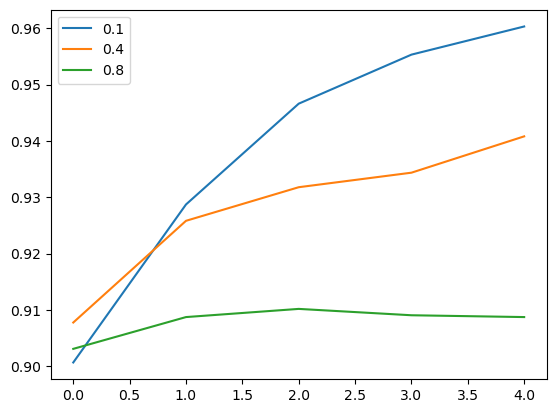

In [32]:
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label = lr)
    #plt.xtick(np.arange(10))
    plt.legend()

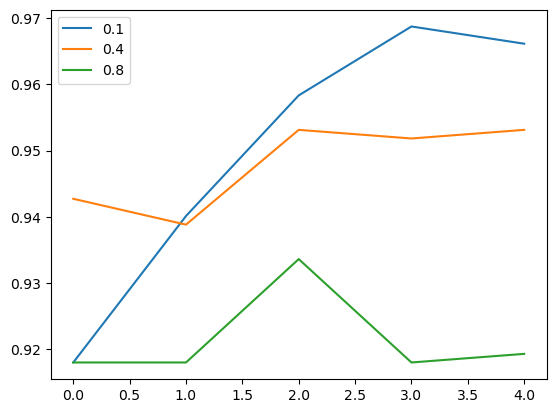

In [33]:
for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label = lr)
    #plt.xtick(np.arange(10))
    plt.legend()

Ceate final model

In [34]:
model = make_model()
EPOCHS = 15
history = model.fit(
train_spectrogram_ds,validation_data=val_spectrogram_ds,
epochs=EPOCHS,
callbacks =[checkpoint],)

Epoch 1/15
97/97 [==============================] - 21s 193ms/step - loss: 0.2594 - accuracy: 0.9026 - val_loss: 0.1760 - val_accuracy: 0.9180
Epoch 2/15


/Users/lesia/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


97/97 [==============================] - 19s 194ms/step - loss: 0.1762 - accuracy: 0.9205 - val_loss: 0.1424 - val_accuracy: 0.9440
Epoch 3/15
97/97 [==============================] - 19s 196ms/step - loss: 0.1386 - accuracy: 0.9424 - val_loss: 0.0976 - val_accuracy: 0.9557
Epoch 4/15
97/97 [==============================] - 19s 195ms/step - loss: 0.1053 - accuracy: 0.9534 - val_loss: 0.0986 - val_accuracy: 0.9544
Epoch 5/15
97/97 [==============================] - 19s 195ms/step - loss: 0.1032 - accuracy: 0.9571 - val_loss: 0.0869 - val_accuracy: 0.9609
Epoch 6/15
97/97 [==============================] - 19s 194ms/step - loss: 0.0884 - accuracy: 0.9645 - val_loss: 0.0745 - val_accuracy: 0.9688
Epoch 7/15
97/97 [==============================] - 19s 193ms/step - loss: 0.0650 - accuracy: 0.9756 - val_loss: 0.0473 - val_accuracy: 0.9779
Epoch 8/15
97/97 [==============================] - 18s 190ms/step - loss: 0.0551 - accuracy: 0.9794 - val_loss: 0.0734 - val_accuracy: 0.9740
Epoch 9/15

Train the model over 15 epochs for demonstration purposes:

Plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

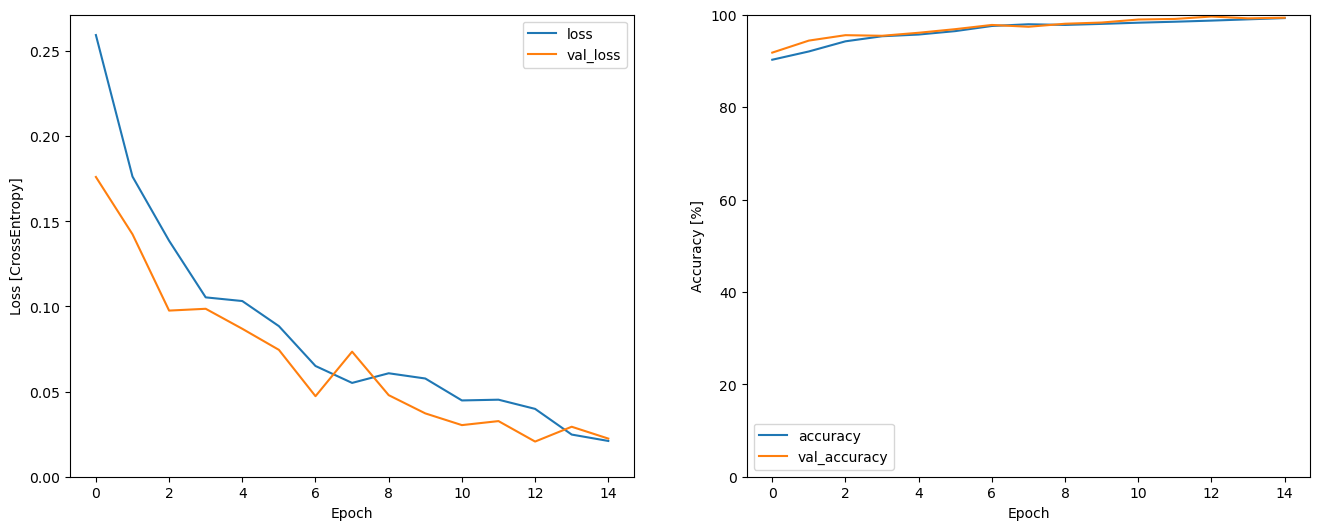

In [35]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [36]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 4s 299ms/step - loss: 0.0161 - accuracy: 0.9936


{'loss': 0.016056524589657784, 'accuracy': 0.9936061501502991}

### Display a confusion matrix

Use a confusion matrix to check how well the model did classifying each of the commands in the test set:


In [37]:
y_pred = model.predict(test_spectrogram_ds)

13/13 [==============================] - 1s 42ms/step


In [38]:
y_pred = tf.argmax(y_pred, axis=1)

In [39]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

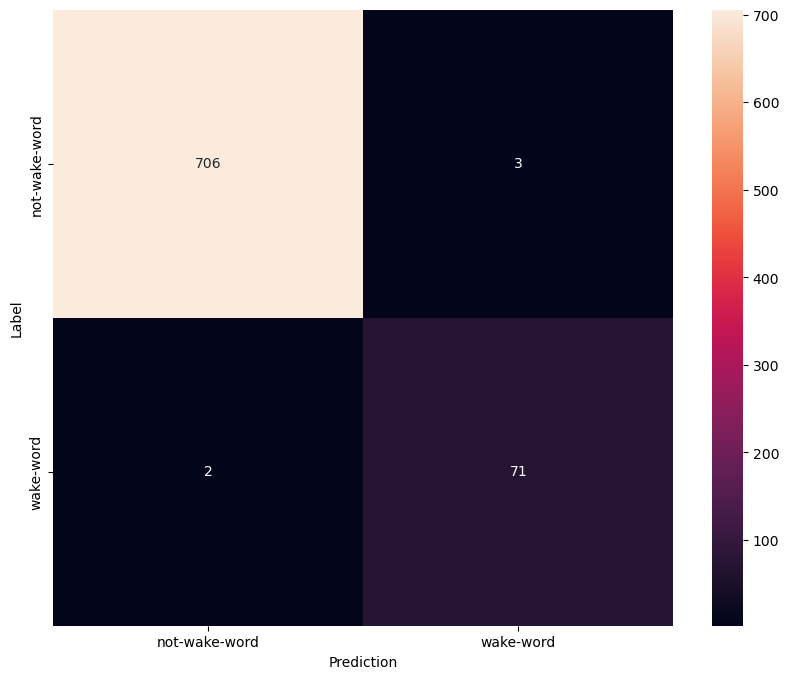

In [40]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

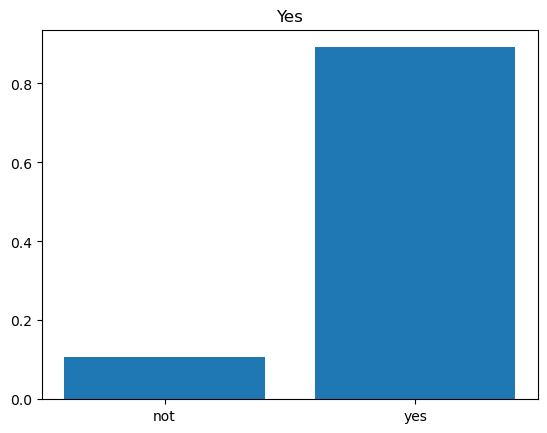

In [41]:
x = data_dir/'wake-word/silero_m_arvin_v4_cyrillic_b_cv_24000.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=32000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['not', 'yes']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Yes')
plt.show()

display.display(display.Audio(waveform, rate=16000))

Result in numbers

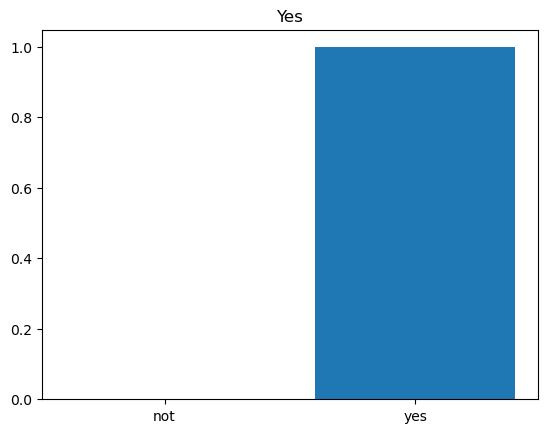

In [42]:
x = data_dir/'wake-word/silero_m_arvin_v4_cyrillic_b_mhr_48000.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=32000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['not', 'yes']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Yes')
plt.show()

display.display(display.Audio(waveform, rate=16000))

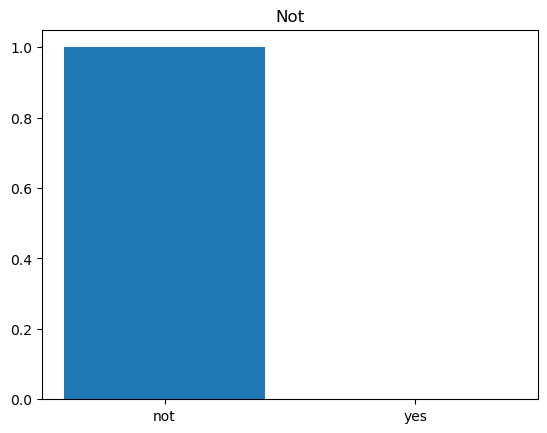

In [44]:
x = data_dir/'not-wake-word/common_voice_ru_18852113.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=32000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['not', 'yes']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Not')
plt.show()

display.display(display.Audio(waveform, rate=16000))

As the output suggests, your model should have recognized the audio command as "no".

## Export the model with preprocessing

In [47]:
model.save('model_v1.h5', save_format = 'h5')

/Users/lesia/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Test run the "export" model:

Save and reload the model, the reloaded model gives identical output:

In [48]:
model = keras.models.load_model('./model_v1.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('marvin_voice.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/zs/2b1vc1b96310yc165107vz9r0000gp/T/tmp5ur2k_ts/assets


INFO:tensorflow:Assets written to: /var/folders/zs/2b1vc1b96310yc165107vz9r0000gp/T/tmp5ur2k_ts/assets
2023-12-18 18:50:58.466011: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-18 18:50:58.466035: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-18 18:50:58.466929: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/zs/2b1vc1b96310yc165107vz9r0000gp/T/tmp5ur2k_ts
2023-12-18 18:50:58.471494: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-18 18:50:58.471519: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/zs/2b1vc1b96310yc165107vz9r0000gp/T/tmp5ur2k_ts
2023-12-18 18:50:58.478009: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2023-12-18 18:50:58.481684: I tensorflow/cc/saved_model/load

### Load the model and predict

In [49]:
import tensorflow.lite as tflite
from tensorflow.io import read_file
from tensorflow.audio import decode_wav
from tensorflow import squeeze
from tensorflow import newaxis
from tensorflow.signal import stft
from tensorflow import abs
import pathlib

In [50]:
x = data_dir/'wake-word/silero_m_arvin_v4_cyrillic_b_cv_24000.wav'
x = read_file(str(x))
x, sample_rate = decode_wav(x, desired_channels=1, desired_samples=32000,)
x = squeeze(x, axis=-1)
waveform = x
spectrogram = stft(x, frame_length=255, frame_step=128)
spectrogram = abs(spectrogram)
x = spectrogram[..., newaxis]
X = x[newaxis,...]

display.display(display.Audio(waveform, rate=32000))

In [52]:
interpreter = tflite.Interpreter(model_path='./marvin_voice.tflite')
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

interpreter.set_tensor(input_index, X)
interpreter.invoke()

preds = interpreter.get_tensor(output_index)

tf.nn.softmax(preds)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.10831517, 0.89168483]], dtype=float32)>